# Automatic Meme Caption Generator

As we preluded in our reports from last week, we saw the image captioning material that we have learned this week to be opportune in teaching us how to make an automatic meme generator. This notebook achieves this goal by writing a "funny" caption overlayed on an input image data. To accomplish this, we found DeepHumor by ilya16 https://github.com/ilya16/deephumor which is a very advanced repo accomplishing this automatic meme captioning. Using the contents of this repo (with an extensive and intelligable ReadMe) we were able to make this operational meme generator with various models designed in DeepHumor that we describe in further detail. At the end of the notebook we have displayed generated memes of standard photos and suprise photos of ourselves!

### Getting the Data
Finding funny meme image and caption data is a little tricky. In this implementation we will be using the memes900k, which is a file that can be downloaded to drive with both image and captioning info. This data consists of 900,000 meme captions that correspond to 300 memes images. The DeepHumor tutorial proved some code cells that helped us get this data in order. 

In [8]:


from IPython.display import clear_output
import os
import sys

def download_from_gdrive(gdrive_id, filename):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$gdrive_id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$gdrive_id -O $filename && rm -rf /tmp/cookies.txt

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE:', DEVICE)

DEVICE: cuda


In [9]:

GDRIVE_ID = '1S4QwcuznRxLlxkIT0Lb6vIuqDTib41B3'
FILE_IDS_NAME = 'file_ids.txt'

download_from_gdrive(GDRIVE_ID, FILE_IDS_NAME)

FILE_IDS = {}
with open(FILE_IDS_NAME, 'r') as f:
    for line in f:
        name, gid = line.strip().split('\t')
        FILE_IDS[name] = gid

clear_output()

In [10]:


LOAD_FROM_GITHUB = True 

if LOAD_FROM_GITHUB:
    print('Loading code from GitHub')
    # will not work while repo is private
    !git clone https://github.com/ilya16/deephumor
else:
    # from Google Drive (the same code)
    print('Loading code from Google Drive')
    os.chdir('/content')
    fname = 'deephumor.zip'
    download_from_gdrive(FILE_IDS[fname], 'deephumor.zip')
    !unzip -o {fname}
    !rm -rf __MACOSX/

os.chdir('/content/deephumor')
!pip install -r requirements.txt
clear_output()

print(f'Loaded code from {"GitHub" if LOAD_FROM_GITHUB else "Google Drive"}')

Loaded code from GitHub


In [11]:
os.chdir('/content')
sys.path.append('/content/deephumor')

In [12]:
DATA_DIR = 'memes900k'
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions_train.txt')

In [13]:


# full dataset
print('Loading the dataset from Google Drive')
fname = f'{DATA_DIR}.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {DATA_DIR}
clear_output()



## Loading in vocabulary and tokenizers from DeepHumor

DeepHumor has already defined and implemented vocabulary and tokenizers (punctuation, character, special tokens etc), so we have taken advantage of these definitions. 


In [14]:
# Word and Chararacter Vocab

from deephumor.data.vocab import Vocab, build_vocab_from_file
from deephumor.data.tokenizers import WordPunctTokenizer, CharTokenizer

LOAD_VOCABULARY = True 
MIN_DF = 5 

tokenizer_words = WordPunctTokenizer()
tokenizer_chars = CharTokenizer()

if LOAD_VOCABULARY:
    print('Loading vocabularies from Google Drive')

    fname = 'vocab.zip'
    download_from_gdrive(FILE_IDS[fname], fname)
    !unzip -o {fname}

    vocab_words = Vocab.load('vocab/vocab_words.txt')
    vocab_chars = Vocab.load('vocab/vocab_chars.txt')
    clear_output()

    print('Loaded vocabularies from Google Drive')
else:
    print(f'Building WordPunct Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_words = build_vocab_from_file(CAPTIONS_FILE, tokenizer_words, min_df=MIN_DF)

    print(f'Building Character Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_chars = build_vocab_from_file(CAPTIONS_FILE, tokenizer_chars, min_df=MIN_DF)


print('\nVocabulary sizes:')
print('WordVocab:', len(vocab_words))
print('CharVocab:', len(vocab_chars))

Loaded vocabularies from Google Drive

Vocabulary sizes:
WordVocab: 36541
CharVocab: 71


So as seen above we now have a vocabulary of 36541 with an additional 71 characters. 

## Split dataset into training set
Here we are just splitting 200 out of all 300 MemeDataset images from DeepHumor for training.


In [15]:
# Build `MemeDataset`

from deephumor.data import MemeDataset

# use this to limit the dataset size (300 classes in total)
NUM_CLASSES = 200 
PAD_IDX = vocab_words.stoi['<pad>']

from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

splits = ['train', 'val', 'test']

datasets_words = {
    # WORD-LEVEL
    split: MemeDataset(DATA_DIR, vocab_words, tokenizer_words, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

datasets_chars = {
    # CHAR-LEVEL
    split: MemeDataset(DATA_DIR, vocab_chars, tokenizer_chars, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

## Implementing the Models
This is the stage where we can look into the methodology of DeepHumor more closely. In their repo, they have defined multiple model approaches to train this captioning tool on. After importing these various models below, we describe the methodology and architecture of the models. The models include captioning LSTM with image-only and image-label encoders, global image embedding for their "base cpationing transformer", and usining spatial image features for captioning transformer LSTM.

In [16]:
#Model loading utilities

from deephumor.models import (
    CaptioningLSTM, 
    CaptioningLSTMWithLabels, 
    CaptioningTransformerBase,
    CaptioningTransformer
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_and_build_model(gdrive_id, ckpt_path, model_class):
    print('Downloading model weights from Google Drive')
    download_from_gdrive(gdrive_id, ckpt_path)
    clear_output()
    print('Downloaded model weights')

    print(f'Building {model_class.__name__} model')
    model = model_class.from_pretrained(ckpt_path).to(DEVICE)
    print(f'Built and loaded {model_class.__name__} model from {ckpt_path}')
    print('# parameters:', count_parameters(model))

    return model

FILE_TO_CLASS = {
    'LSTMDecoderWords.best.pth': CaptioningLSTM,
    'LSTMDecoderChars.best.pth': CaptioningLSTM,
    'LSTMDecoderWithLabelsWords.best.pth': CaptioningLSTMWithLabels,
    'LSTMDecoderWithLabelsChars.best.pth': CaptioningLSTMWithLabels,
    'TransformerDecoderBaseWords.best.pth': CaptioningTransformerBase,
    'TransformerDecoderBaseChars.best.pth': CaptioningTransformerBase,
    'TransformerDecoderWords.best.pth': CaptioningTransformer,
    'TransformerDecoderChars.best.pth': CaptioningTransformer
}

IMPORTANT: if some cell in this section crashed, run it again, it should be fine

## Word-based models

###### LSTM Decoder

This first model includes captions LSTM with image-only encoders. Taking in an input image, the image data is passed through a pretrained ResNet50 using the ImageNet dataset we familiarized ourselves with and explored last semester. This ResNet output is then vectorized and passed through LSTM along with word embeddings describing the context of the image. These LSTM layers then judge the image along with the embeddings to contextualize and generate an output vector that is passed through Softmax to provide a final caption sequence. 

In [17]:
# Load and build `w_lstm_model`

ckpt_path = 'LSTMDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTM model
Built and loaded CaptioningLSTM model from LSTMDecoderWords.best.pth
# parameters: 44808381


###### LSTM Decoder with labels
The following model now integrates image and label encodings to caption LSTM. This is a very similar model architecture to the one perviously described however the vectorization of the input image data is concatinated with the mean of input labels affilliated with the image. This is not to be confused with the word embeddings, these labels more so "title" the image for further input data clarity rather than give embedded context for deriving a "funny" output. Once the mean input labels are concatinated with the input image data, this resulting state is vectorized again and follows the same LSTM + softmax structure for the image data and word embeddings to output the funny meme caption sequence. 

In [18]:
# Load and build `w_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model_labels = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsWords.best.pth
# parameters: 45333181


###### Tranformer with global image embedding

Using global image embedding for a transformer approach, this model (similarly as to LSTM approaches) takes in the image, passes it through a pretrained ResNet and vectorizes the data. This vector is then integrated (through vecotr->matrix multiplication) to the "shifted right" output embedding for the transformer. Along with positional embeddings, this information is then passed through N parallel masked multi-head attention networks that are added and normalized against the origional data. This trains all elements of the input vectors in parralel which ultimatemly this makes training much faster. Finally, we feed this foreward to encode the state and output Softmax that results in our meme caption.

In [19]:
#@markdown Load and build `w_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_base_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseWords.best.pth
# parameters: 48027325


###### Tranformer with spacial image features

Finially we combine the previous models to develop a captioning model that integrates transformer with LSTM whil e considering spatial image features. To do this, after the image data is passed through the pretrained ResNet layer, average pooling is linearized with the direct resnet output and integrated with output embeddings while also being inputted into the multihead attention network that is added. This multihead attention network is included in the parallel training of vectorized elements after the masking of the neceessary elements happens. In this case attention is given in parallel all at once. The output here is again the vectorized and softmaxed sequence data. 

In [20]:
# Load and build `w_transformer_model`

ckpt_path = 'TransformerDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformer model
Built and loaded CaptioningTransformer model from TransformerDecoderWords.best.pth
# parameters: 51182269


## Character-based models
The character based models follow the same structures accordingly as i just described.

###  LSTM Decoder

In [21]:
# Load and build `ch_lstm_model`

ckpt_path = 'LSTMDecoderChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTM model
Built and loaded CaptioningLSTM model from LSTMDecoderChars.best.pth
# parameters: 7426631


###  LSTM with labels

In [ ]:
# Load and build `ch_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model_labels = load_and_build_model(gdrive_id, ckpt_path, model_class)

###  Tranformer with global image embedding

In [23]:
# Load and build `ch_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_base_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseChars.best.pth
# parameters: 10645575


### Tranformer with spacial image features

In [24]:
# Load and build `ch_transformer_model`

ckpt_path = 'TransformerDecoderChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformer model
Built and loaded CaptioningTransformer model from TransformerDecoderChars.best.pth
# parameters: 13800519


# 3. Meme Generation

In [25]:
IMG_DIR = 'images_inference'

fname = 'inference.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {fname}
clear_output()

In [26]:
#@ Meme generation and captioning function

from PIL import Image
from deephumor.experiments import text_to_seq, seq_to_text, split_caption
from deephumor.imaging import memeify_image
FONT_PATH = 'deephumor/fonts/impact.ttf'

def get_a_meme(model, img_torch, img_pil, caption, T=1., beam_size=7, top_k=50, 
               labels = None, mode = 'word', device=DEVICE):
    if mode == 'word':
        vocabulary = vocab_words
        datasets = datasets_words  #We distinguish here between words or characters (below)
        delimiter=' '
        max_len = 32
    else:
        vocabulary = vocab_chars
        datasets = datasets_chars
        delimiter=''
        max_len = 128
    
    model.eval()
    if caption is not None:
        caption_tensor = torch.tensor(datasets['train']._preprocess_text(caption)[:-1]).unsqueeze(0).to(device)  #Make caption!
    else:
        caption_tensor = None

    if labels is None:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k.  #Add to label.
            )
    else:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, label=labels, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    
    pred_seq = output_seq
    text = seq_to_text(pred_seq, vocab=vocabulary, delimiter=delimiter)

    top, bottom = split_caption(text, num_blocks=2) #split so we can make this look like meme format

    return memeify_image(img_pil, top, bottom, font_path=FONT_PATH)

## Make memes!
In the DeepHumor demo, they use a couple classic meme figures that we have initially used below to see if you meme generator is doing good. Then we had the bright idea of inputting our own images, images of our class TA and Professor, and then seeing what it comes up with! Obviously, we have no control over the exact text this is generating.

Enjoy!

## Images from the dataset

I

In [27]:
# Image from dataset
label = 'PTSD Karate Kyle' 
labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
img_torch = datasets_words['train'].images[label]
img_pil = Image.open(datasets_words['train'].templates[label])
img_torch = img_torch.unsqueeze(0).cuda()
caption = None # "Your mom"

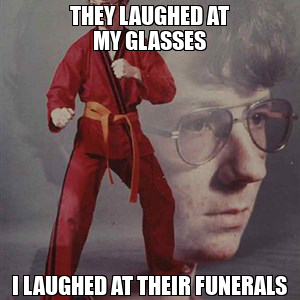

In [29]:
w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

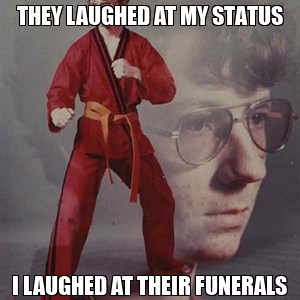

In [30]:
ch_lstm_model.cuda()

get_a_meme(
    model=ch_lstm_model, T=1.1, 
    beam_size=7,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='char',
    device='cuda'
)

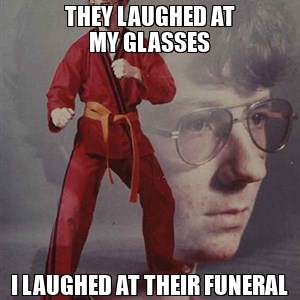

In [31]:
w_transformer_model.cuda()

get_a_meme(
    model=w_transformer_model, T=1.0, 
    beam_size=10,
    top_k=70,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

In [32]:
# # New image
label = 'Willy Wonka' 
labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
img_pil = Image.open(os.path.join(IMG_DIR, 'druzko.jpg'))
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

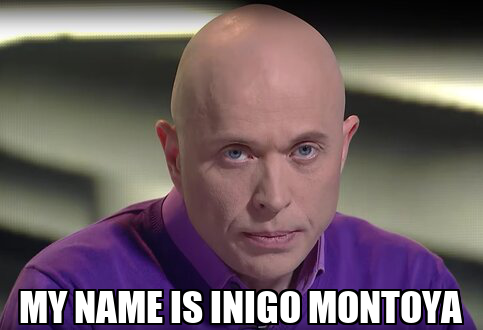

In [33]:
w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

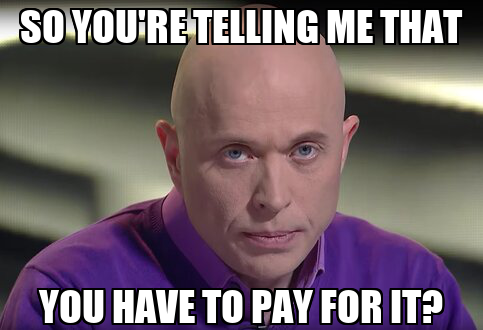

In [34]:
ch_lstm_model.cuda()

get_a_meme(
    model=ch_lstm_model, T=1.1, 
    beam_size=7,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='char',
    device='cuda'
)

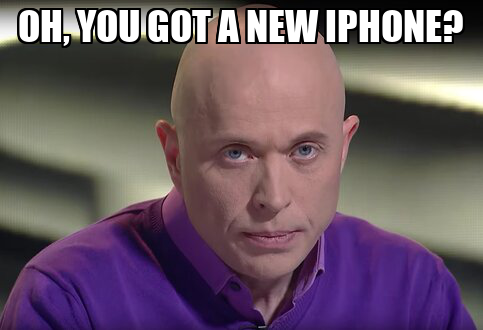

In [35]:
w_transformer_model.cuda()

get_a_meme(
    model=w_transformer_model, T=1.0, 
    beam_size=10,
    top_k=70,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

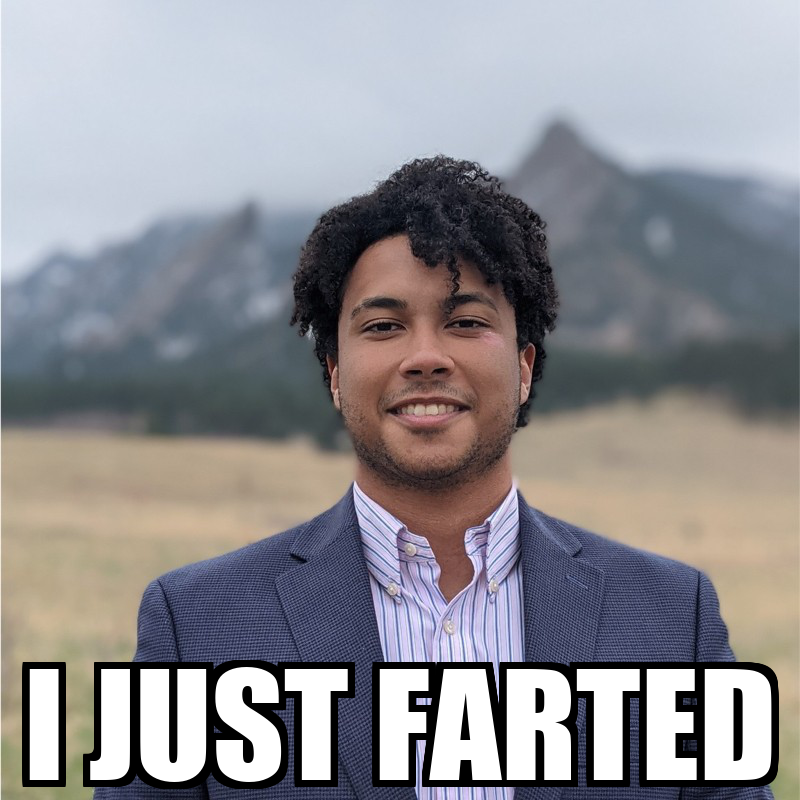

In [36]:
img_pil = Image.open('MyPhoto.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

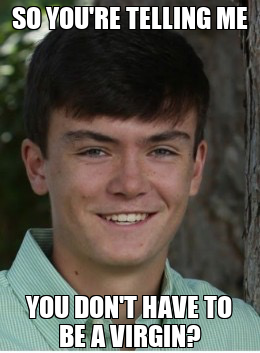

In [43]:
img_pil = Image.open('headshot.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

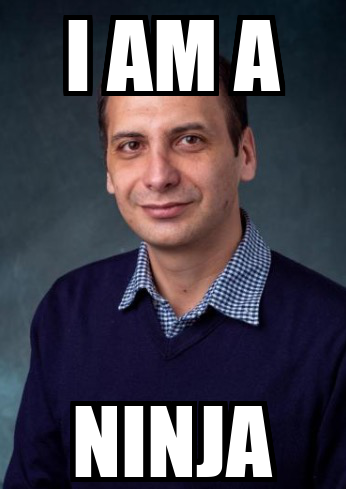

In [77]:
img_pil = Image.open('Maziar.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

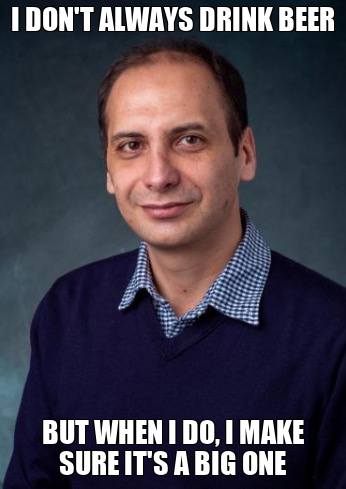

In [82]:
img_pil = Image.open('Maziar.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

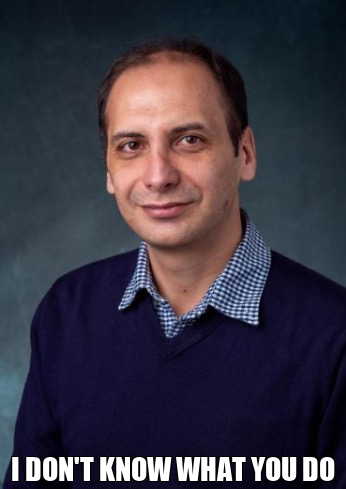

In [88]:
img_pil = Image.open('Maziar.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

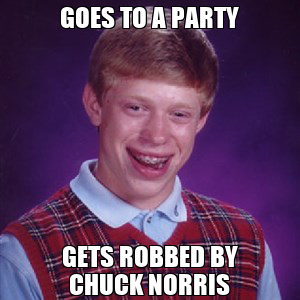

In [127]:
img_pil = Image.open('/content/memes900k/images/bad-luck-brian.jpg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

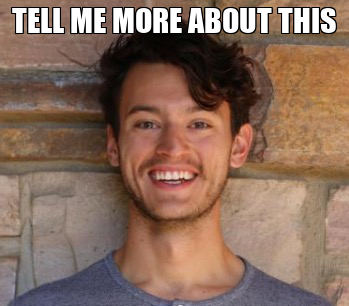

In [143]:
img_pil = Image.open('Theodore.jpeg')
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = None #"so tired" # "hey girl"

w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

## Conclusion
In this notebook, we accomplished our goal that stemmed from our in class topics and made a funny meme generator! We also got some good experience sifting through a mature github repository (something we are somewhat used to avoiding cause it is hard to get everything to work many times). Following the code and opening some of the fundamental functions that we merely uploaded here in tensorboard. The tensorboard function is useful and we are considering integrating this with our future work that we develop completely from scratch to gain experience. 
